In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import os
df = pd.read_csv('F:/Artificial intelligence stuffs/fliprobo projects/Projects/project 1/train.csv')

In [3]:
df.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [4]:
df.shape

(38932, 5)

In [5]:
df.describe()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
count,38932,38932,38932,38932,38932
unique,38932,38932,11,3,2
top,id30509,My husband and our - teenage boys stayed at th...,Firefox,Desktop,happy
freq,1,1,7367,15026,26521


In [6]:
#As there is no use of User_ID,Browser_Used and Device_used, so i have decided to drop those columns
df.drop(columns = ['User_ID', 'Browser_Used', 'Device_Used'], inplace = True)

In [7]:
df['Is_Response'].value_counts()

happy        26521
not happy    12411
Name: Is_Response, dtype: int64

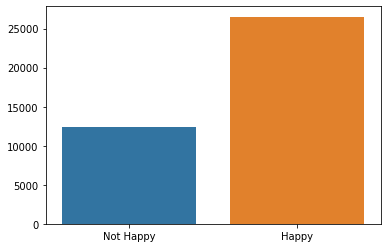

In [8]:
zero = len(df[df.Is_Response =='not happy'])
one = len(df[df.Is_Response =='happy'])

li_response = [zero,one]
label_response = ['Not Happy','Happy']

index_response = np.arange(len(li_response))

sns.barplot(label_response,li_response)
plt.show()

In [9]:
df['Description'][100]

'Booked this hotel on a special deal, stay - nights and get - free. Also offered $-- credit towards breakfast each day, which was advertised as """"""""""""""""""""""""""""""""free breakfast"""""""""""""""""""""""""""""""" as well as free unlimited mini bar in room, free wifi, etc. Most of that was great, hotel was very nice and clean as well as updated, the staff was extremely courteous and knowledgeable. Only issues we had were on the deal we booked as there seemed to be a catch to each of the offerings... perhaps their marketing was a little bit more generous than the actual offerings were in reality. - night free was great, except that they charge you for that night anyway upfront then credit back to you several days after you leave... not the best if you didn\'t plan on taking that money out of your wallet on a family trip (we booked - rooms, so the extra charge was $---). Breakfast credit sounded great except that a """"""""""""""""""""""""""""""""hot"""""""""""""""""""""""""""""

In [10]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()
twitter_handle = r'@[A-Za-z0-9_]+'                        
url_handle = r'http[^ ]+'                                  
combined_handle = r'|'.join((twitter_handle, url_handle))  
www_handle = r'www.[^ ]+'                                  # remove website URLs that start with 'www.'
punctuation_handle = r'\W+'

In [11]:
from nltk.corpus import stopwords
stopwords = set(pd.read_csv('stopwords.txt', sep='\n', header=0).stopword)

In [12]:
def process_text(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()

    try:
        text = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        text = souped

    cleaned_text = re.sub(punctuation_handle, " ",(re.sub(www_handle, '', re.sub(combined_handle, '', text)).lower()))
    cleaned_text = ' '.join([word for word in cleaned_text.split() if word not in stopwords])

    return (" ".join([word for word in tokenizer.tokenize(cleaned_text) if len(word) > 1])).strip()

In [13]:
cleaned_text = []

for text in df.Description:
    cleaned_text.append(process_text(text))

clean_text = pd.DataFrame({'clean_text' : cleaned_text})
df = pd.concat([df, clean_text], axis = 1)

df.sample(5)

,Description,Is_Response,clean_text
33239,I stayed at the Alexis on business for a week....,not happy,stayed alexis business week staff friendly che...
7619,We stayed here for two nights and were very sa...,not happy,stayed nights satisfied conference hilton cost...
37405,I booked this hotel on the sole discretion of ...,happy,booked hotel sole discretion tripadvisor revie...
15067,The staff at this hotel are wonderful. From th...,not happy,staff hotel wonderful second walk treat like r...
5324,Some entire floors have very strong mold probl...,not happy,entire floors strong mold problem rooms strong...


In [14]:
from sklearn.model_selection import train_test_split

attribute = df.clean_text
target = df.Is_Response

In [15]:
attribute_train, attribute_test, target_train, target_test = train_test_split(attribute, target, test_size = 0.1, random_state = 225)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tvec = TfidfVectorizer()
clf2 = LogisticRegression()

In [17]:
from sklearn.pipeline import Pipeline

model = Pipeline([('vectorizer',tvec)
                 ,('classifier',clf2)])

model.fit(attribute_train, target_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, inter

In [18]:
example_text = ["I'm very happy now"]
example_result = model.predict(example_text)

print(example_result)

['happy']


In [19]:
from sklearn.metrics import confusion_matrix

verdict = model.predict(attribute_test)

confusion_matrix(verdict, target_test)

array([[2424,  335],
       [ 147,  988]], dtype=int64)

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Accuracy : ", accuracy_score(verdict, target_test))
print("Precision : ", precision_score(verdict, target_test, average = 'weighted'))
print("Recall : ", recall_score(verdict, target_test, average = 'weighted'))

Accuracy :  0.8762198253723678
Precision :  0.8856843363140553
Recall :  0.8762198253723678
